**Goal**    
Exploration of various metrics and behaviours for different model selection criteria

In [14]:
import sys
sys.path.insert(1, "..")
import pprint
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal, spearmanr
import matplotlib.pyplot as plt
import pprint
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

In [15]:
# Stolen from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(mu, K, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    cov = K
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0] 

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [16]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value


def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    # Use kwargs if not None, otherwise use the default values
    train_x = kwargs.get("train_x", model.train_inputs[0])
    train_y = kwargs.get("train_y", model.train_targets)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = 1e-10
    opts.limited_mem_size = 100
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = 0
    opts.halt_on_linesearch_bracket = False
    opts.double_precision = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = metrics.log_normalized_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = 5
    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = metrics.log_normalized_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    print(f"Jacobian: {torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True)}")
    # Return the trained model
    return loss, model, likelihood

def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y


# Find all points inside the confidence ellipse
def percentage_inside_ellipse(mu, K, points, sigma_level=2):
    L = np.linalg.cholesky(K)
    threshold = sigma_level ** 2
    count = 0
    for point in points:
        res = np.array(point - mu) @ np.linalg.inv(L)
        if res @ res <= threshold:
            count += 1
    return count / len(points)

In [17]:
from gpytorch.kernels import Kernel
from gpytorch.constraints import Interval, Positive
from gpytorch.priors import Prior

import warnings
from typing import Optional, Union

import torch
from linear_operator.operators import LinearOperator, MatmulLinearOperator, RootLinearOperator
from torch import Tensor

class AffineKernel(Kernel):
    r"""
    Computes a covariance matrix based on the Linear kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::
        \begin{equation*}
            k_\text{Linear}(\mathbf{x_1}, \mathbf{x_2}) = v\mathbf{x_1}^\top
            \mathbf{x_2}.
        \end{equation*}

    where

    * :math:`v` is a variance parameter.


    .. note::

        To implement this efficiently, we use a
        :obj:`~linear_operator.operators.RootLinearOperator` during training
        and a :class:`~linear_operator.operators.MatmulLinearOperator` during
        test. These lazy tensors represent matrices of the form :math:`\mathbf
        K = \mathbf X \mathbf X^{\prime \top}`. This makes inference efficient
        because a matrix-vector product :math:`\mathbf K \mathbf v` can be
        computed as :math:`\mathbf K \mathbf v = \mathbf X( \mathbf X^{\prime
        \top} \mathbf v)`, where the base multiply :math:`\mathbf X \mathbf v`
        takes only :math:`\mathcal O(ND)` time and space.

    :param variance_prior: Prior over the variance parameter. (Default `None`.)
    :param variance_constraint: Constraint to place on variance parameter. (Default: `Positive`.)
    :param active_dims: List of data dimensions to operate on. `len(active_dims)` should equal `num_dimensions`.
    """

    def __init__(
        self,
        num_dimensions: Optional[int] = None,
        offset_prior: Optional[Prior] = None,
        variance_prior: Optional[Prior] = None,
        variance_constraint: Optional[Interval] = None,
        **kwargs,
    ):
        super(AffineKernel, self).__init__(**kwargs)
        if variance_constraint is None:
            variance_constraint = Positive()

        if num_dimensions is not None:
            # Remove after 1.0
            warnings.warn("The `num_dimensions` argument is deprecated and no longer used.", DeprecationWarning)
            self.register_parameter(name="offset", parameter=torch.nn.Parameter(torch.zeros(1, 1, num_dimensions)))
        if offset_prior is not None:
            # Remove after 1.0
            warnings.warn("The `offset_prior` argument is deprecated and no longer used.", DeprecationWarning)
        self.register_parameter(name="raw_variance", parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1)))
        if variance_prior is not None:
            if not isinstance(variance_prior, Prior):
                raise TypeError("Expected gpytorch.priors.Prior but got " + type(variance_prior).__name__)
            self.register_prior("variance_prior", variance_prior, lambda m: m.variance, lambda m, v: m._set_variance(v))

        self.register_constraint("raw_variance", variance_constraint)

    @property
    def variance(self) -> Tensor:
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value: Union[float, Tensor]):
        self._set_variance(value)

    def _set_variance(self, value: Union[float, Tensor]):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_variance)
        self.initialize(raw_variance=self.raw_variance_constraint.inverse_transform(value))

    def forward(
        self, x1: Tensor, x2: Tensor, diag: Optional[bool] = False, last_dim_is_batch: Optional[bool] = False, **params
    ) -> LinearOperator:
        x1_ = x1 - torch.ones_like(x1)
        x1_ = x1_ * self.variance.sqrt()
        if last_dim_is_batch:
            x1_ = x1_.transpose(-1, -2).unsqueeze(-1)

        if x1.size() == x2.size() and torch.equal(x1, x2):
            # Use RootLinearOperator when x1 == x2 for efficiency when composing
            # with other kernels
            prod = RootLinearOperator(x1_)

        else:
            x2_ = x2 - torch.ones_like(x2)
            x2_ = x2_ * self.variance.sqrt()
            if last_dim_is_batch:
                x2_ = x2_.transpose(-1, -2).unsqueeze(-1)

            prod = MatmulLinearOperator(x1_, x2_.transpose(-2, -1))

        if diag:
            return prod.diagonal(dim1=-1, dim2=-2)
        else:
            return prod


In [18]:
# from metrics.py
# Used to generate the parameter prior for the specific class of GP kernel and calculate the log propability of this specific parametrization
#metrics.prior_distribution()
#metrics.log_normalized_prior()

# Definitions

In [19]:
# Global name
data_generation = "2pi periodic" # linear, parabola, "x^2 + x + 1", "2pi periodic"; Optionally also "linear_noise" etc.
COUNT = 50
evaluating_GP_model = "PER" # RBF, Linear, RQ, MAT32, MAT52, PER; Optionally also "C*RBF" etc.
# timestamp in yyyy-mm-dd-hh-mm-ss
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

START = -1 
END = 1
log_path = f"logs/{timestamp}_{data_generation}{COUNT}_{START}:{END}-{evaluating_GP_model}"
# Create the log directory
os.makedirs(log_path)

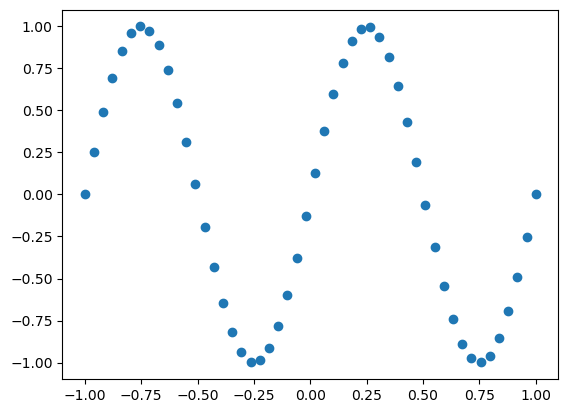

In [20]:
# Data
torch.manual_seed(42)

train_x = torch.linspace(START, END, COUNT)

if "linear" in data_generation:
    train_y = torch.linspace(START, END, COUNT)
elif data_generation == "2pi periodic":
    train_y = torch.sin(2 * np.pi * train_x)
elif data_generation == "x^2 + x":
    train_y = train_x**2 + train_x 
elif data_generation == "x^2 + x + 1":
    train_y = train_x**2 + train_x + torch.ones_like(train_x)
elif data_generation == "parabola":
    train_y = train_x**2
elif data_generation == "cubic":
    train_y = train_x**3
elif data_generation == "2_points":
    train_y = torch.tensor([0, 1])
if "noise" in data_generation:
    train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
plt.plot(train_x, train_y, "o")

# Model definition

In [21]:
# RBF, Linear, RQ, MAT32, MAT52
if evaluating_GP_model == "RBF":
    kernel = gpytorch.kernels.RBFKernel()
elif evaluating_GP_model == "LIN*LIN*LIN*LIN":
    kernel = gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
elif evaluating_GP_model == "LIN*LIN*LIN":
    kernel = gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
elif evaluating_GP_model == "LIN*LIN":
    kernel = gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
elif evaluating_GP_model == "LIN":
    kernel = gpytorch.kernels.LinearKernel()
elif evaluating_GP_model == "AFF*AFF*AFF*AFF":
    kernel = AffineKernel() * AffineKernel() * AffineKernel() * AffineKernel()
elif evaluating_GP_model == "AFF*AFF*AFF":
    kernel = AffineKernel() * AffineKernel() * AffineKernel()
elif evaluating_GP_model == "AFF*AFF":
    kernel = AffineKernel() * AffineKernel()
elif evaluating_GP_model == "AFF":
    kernel = AffineKernel()
elif evaluating_GP_model == "PER":
    kernel = gpytorch.kernels.PeriodicKernel()
elif evaluating_GP_model == "RQ":
    kernel = gpytorch.kernels.RQKernel()
elif evaluating_GP_model == "MAT32":
    kernel = gpytorch.kernels.MaternKernel(nu=3/2)
elif evaluating_GP_model == "MAT52":
    kernel = gpytorch.kernels.MaternKernel(nu=5/2)


if "C*" in evaluating_GP_model:
    kernel = gpytorch.kernels.ScaleKernel(kernel)


In [22]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel)

# Training

In [23]:
loss, model, likelihood = optimize_hyperparameters(model, likelihood)
MAP = -loss*COUNT

/home/besginow/anaconda3/envs/sageNewGPyTorch/lib/python3.11/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718618105212/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.5595], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[5.4322]], requires_grad=True)), ('covar_module.raw_period_length', Parameter containing:
tensor([[0.5413]], requires_grad=True))] w. loss: -2.817908763885498
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.5595], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[5.4322]], requires_grad=True)), ('covar_module.raw_period_length', Parameter containing:
tensor([[0.5413]], requires_grad=True))] w. loss: -2.817908763885498
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-12.5595], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[5.4322]], requires_grad=True)), ('covar_module.raw_period_length', Parameter containing:
tensor([[0.5413]], requires_gra

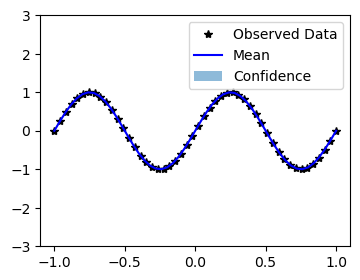

In [24]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(START, END, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    plt.savefig(f"{log_path}/gp_fit.png")

# MAP

In [25]:
MAP

tensor(140.8954, grad_fn=<MulBackward0>)

# Laplace

In [49]:
model.train()
likelihood.train()

lap, lap_log = metrics.calculate_laplace(model, MAP, with_prior=True, param_punish_term=0.0) # Param_punish 0.0, -1.0, BIC
lap_param_mu = lap_log["parameter values"]
# Wait a minute, isn't the Hessian the inverse of the covariance matrix? Yes, see Murphy PML 1 eq. (7.228)
lap_param_cov_matr = torch.linalg.inv(lap_log["corrected Hessian"])

In [27]:
print(lap)
pprint.pprint(lap_log)

tensor(134.8148, grad_fn=<AddBackward0>)
{'Approximation time': 0.00037670135498046875,
 'Correction time': 0.00020575523376464844,
 'Derivative time': 0.3962726593017578,
 'Jacobian': (tensor([0.0068], dtype=torch.float32, grad_fn=<AddBackward0>),
              tensor([[0.0036]], dtype=torch.float32, grad_fn=<AddBackward0>),
              tensor([[-10.3925]], dtype=torch.float32, grad_fn=<AddBackward0>)),
 'MAP': tensor(-140.8954, dtype=torch.float32, grad_fn=<NegBackward0>),
 'Prior generation time': 0.00014901161193847656,
 'Total time': 0.39710044860839844,
 'corrected Hessian': tensor([[ 6.2832e+00, -8.6690e-08,  2.8791e-01],
        [-8.6690e-08,  6.2832e+00, -3.6172e-01],
        [ 2.8791e-01, -3.6172e-01,  1.2013e+06]]),
 'correction term': 0.0,
 'diag(constructed eigvals)': tensor([6.2832e+00, 6.2832e+00, 1.2013e+06]),
 'diag(prior var)': tensor([12.8388,  5.2393,  0.9862]),
 'laplace without replacement': tensor(137.0751, grad_fn=<SubBackward0>),
 'likelihood approximation': 

# AIC

In [28]:
model.train()
likelihood.train()

aic, aic_log = metrics.calculate_AIC(MAP, len(list(model.parameters())))
print(aic)
print(aic_log)

tensor(-275.7909, dtype=torch.float32, grad_fn=<RsubBackward1>)
{'punish term': 6, 'Total time': 0.00044846534729003906, 'loss term': tensor(281.7909, dtype=torch.float32, grad_fn=<MulBackward0>)}


# BIC

In [29]:
model.train()
likelihood.train()

bic, bic_log = metrics.calculate_BIC(MAP, len(list(model.parameters())), torch.tensor(COUNT))
print(bic)
print(bic_log)

tensor(-270.0548, grad_fn=<SubBackward0>)
{'punish term': tensor(11.7361), 'Total time': 0.0003685951232910156, 'loss term': tensor(281.7909, dtype=torch.float32, grad_fn=<MulBackward0>)}


# Nested Sampling (Model evidence)

In [30]:
model.train()
likelihood.train()

model_evidence, model_evidence_log = metrics.NestedSampling(model, 
                                                            print_progress=True,
                                                            store_samples = True,
                                                            store_likelihoods = True,
                                                            store_full = True,
                                                            pickle_directory = f"{log_path}/"
                                                            )
print(model_evidence)
print(model_evidence_log)

Random seed: 90502


0it [00:00, ?it/s]/home/besginow/anaconda3/envs/sageNewGPyTorch/lib/python3.11/site-packages/dynesty/dynamicsampler.py:447: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
17414it [04:23, 66.19it/s, batch: 5 | bound: 10 | nc: 1 | ncall: 161022 | eff(%): 10.794 | loglstar: 146.631 < 153.265 < 151.843 | logz: 137.160 +/-  0.123 | stop:  0.979]            


137.18826877193445
{'Sample time': 263.102933883667, 'log Z': 137.18826877193445, 'log Z err': 0.10654333292198218, 'prior mean': tensor([[-3.5164],
        [ 0.7778],
        [ 0.6485]]), 'prior cov': tensor([[12.8388,  0.0000,  0.0000],
        [ 0.0000,  5.2393,  0.0000],
        [ 0.0000,  0.0000,  0.9862]]), 'dynamic': True, 'num sampled': 17414, 'parameter statistics': {'mu': array([-11.38339011,   4.34017049,   0.79617432]), 'std': array([3.65881332, 2.81619987, 0.68830201])}, 'res file': 'logs/2024-10-07-08-37-54_2pi periodic50_-1:1-PER/Nested_results/res_1728283420.4728742.pkl'}


In [31]:
# unpickle the log file
with open(f"{model_evidence_log['res file']}", "rb") as f:
    res = pickle.load(f)

In [32]:
# Calculate the amount of samples that are covered by the 1 sigma and 2 sigma interval based on the lap_mu and lap_cov values
lap_2_sig_coverage = percentage_inside_ellipse(lap_param_mu.flatten().numpy(), lap_param_std.numpy(), res.samples)
lap_2_sig_coverage

0.7547375674744459

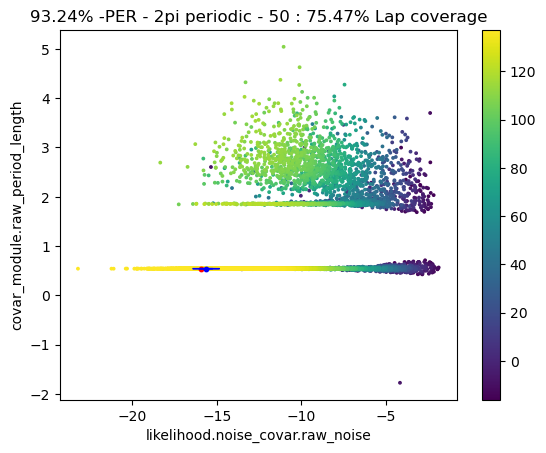

In [52]:

f, ax = plt.subplots()

param_names = [l[0] for l in list(model.named_parameters())]
xdim = 0
ydim = 2

# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logz)
best_hyperparameters = res.samples[best_idx]

# Do an outlier cleanup on res.logz
logz_mean = np.mean(res.logz) # model_evidence_log["parameter statistics"]["mu"] #
logz_std = np.std(res.logz)   # model_evidence_log["parameter statistics"]["std"]#
std_filter = -0.0
mask = res.logz >= logz_mean+std_filter*logz_std



likelihood_surface_scatter = ax.scatter(res.samples[:,xdim][mask], res.samples[:,ydim][mask], c=res.logz[mask], s=3)
# Best found hyperparameters
ax.scatter(best_hyperparameters[xdim], best_hyperparameters[ydim], c="r", s=10)
# Plot the std points
lap_mu_filtered = lap_param_mu.numpy()[[xdim, ydim]] 
lap_cov_filtered = lap_param_cov_matr.numpy()[[xdim, ydim]][:,[xdim, ydim]]
lap_var_ellipse_x, lap_var_ellipse_y = get_std_points(lap_mu_filtered.flatten(), lap_cov_filtered)
#plt.scatter(lap_var_ellipse_x, lap_var_ellipse_y, c="b", s=1)
confidence_ellipse(lap_mu_filtered, lap_cov_filtered, ax, n_std=1, edgecolor='b', lw=1)
confidence_ellipse(lap_mu_filtered, lap_cov_filtered, ax, n_std=2, edgecolor='b', lw=1)
ax.scatter(lap_param_mu[xdim], lap_param_mu[ydim], c="b", s=10)

plt.title(f"{((sum(mask)/res.logz.size)*100):.2f}% -{evaluating_GP_model} - {data_generation} - {COUNT} : {lap_2_sig_coverage*100:.2f}% Lap coverage")
plt.ylabel(param_names[ydim])
plt.xlabel(param_names[xdim])
plt.colorbar(likelihood_surface_scatter)
f.savefig(f"{log_path}/likelihood_surface_>={logz_mean:.2f}{std_filter:.2f}_x{xdim}y{ydim}.png")

In [34]:
all_logs = {"MAP": MAP, "Laplace": lap, "AIC": aic, "BIC": bic, "Model Evidence": model_evidence,
            "Laplace Log": lap_log, "AIC Log": aic_log, "BIC Log": bic_log, "Model Evidence Log": model_evidence_log} 
pickle.dump(all_logs, open(f"{log_path}/all_logs.pkl", "wb"))

# Summarizing results

In [35]:
# Print a table containing the MLL, MAP, Laplace approximation, AIC, BIC and the model evidence
print(f"\n{'MAP':<10} | {'Laplace':<10} | {'AIC':<10} | {'AIC Scaled':<10} | {'BIC':<10} | {'BIC Scaled':<10} | {'Model Evidence':<10}")
print(f"--|--|--|--|--|--|--")
print(f"{MAP:<10.2f} | {lap:<10.2f} | {aic:<10.2f} | {aic*(-0.5):<10.2f} | {bic:<10.2f} | {bic*(-0.5):<10.2f} | {model_evidence:<10.2f}\n")


MAP        | Laplace    | AIC        | AIC Scaled | BIC        | BIC Scaled | Model Evidence
--|--|--|--|--|--|--
140.90     | 134.81     | -275.79    | 137.90     | -270.05    | 135.03     | 137.19    



In [36]:
res_table = f"\n{'MAP':<10} | {'Laplace':<10} | {'AIC':<10} | {'AIC Scaled':<10} | {'BIC':<10} | {'BIC Scaled':<10} | {'Model Evidence':<10}\n" + \
            f"{MAP:<10.2f} | {lap:<10.2f} | {aic:<10.2f} | {aic*(-0.5):<10.2f} | {bic:<10.2f} | {bic*(-0.5):<10.2f} | {model_evidence:<10.2f}\n"
with open(f"{log_path}/res_table.md", "w") as f:
    f.write(res_table)

# In depth analysis

	- Eigenvalues Hessian
	- Condition number Hessian
	- Eigenvalues GP?
	- Condition number GP?
	- Correction terms
	- Laplace without correction
	- Correction terms of AIC and BIC
	- Neg MLL (Un-Scaled)
	- MSE of the GPs posterior mean
	- Percentage of training-points covered in the GP's $2\sigma$ interval
	- With or without Z-scaling of the data? Compare several runs to see how they compare ⏫ 


In [37]:
# Log keys
print(lap_log.keys())
print(aic_log.keys())
print(bic_log.keys())
print(model_evidence_log.keys())


dict_keys(['MAP', 'punish term', 'laplace without replacement', 'correction term', 'num_replaced', 'parameter list', 'Jacobian', 'parameter values', 'corrected Hessian', 'diag(constructed eigvals)', 'original symmetrized Hessian', 'prior mean', 'diag(prior var)', 'likelihood approximation', 'Derivative time', 'Approximation time', 'Correction time', 'Prior generation time', 'Total time'])
dict_keys(['punish term', 'Total time', 'loss term'])
dict_keys(['punish term', 'Total time', 'loss term'])
dict_keys(['Sample time', 'log Z', 'log Z err', 'prior mean', 'prior cov', 'dynamic', 'num sampled', 'parameter statistics', 'res file'])


## Eigenvalues Hessian

In [38]:
print(lap_log["corrected Hessian"])
print(lap_log["original symmetrized Hessian"])
print(f"original symmetrized Hessian eigvals {torch.linalg.eig(lap_log['original symmetrized Hessian'])}")
print(lap_log["corrected Hessian"] - lap_log["original symmetrized Hessian"])

tensor([[ 6.2832e+00, -8.6690e-08,  2.8791e-01],
        [-8.6690e-08,  6.2832e+00, -3.6172e-01],
        [ 2.8791e-01, -3.6172e-01,  1.2013e+06]])
tensor([[ 7.6525e-01,  6.8417e-03,  2.8791e-01],
        [ 6.8417e-03,  5.6141e-01, -3.6172e-01],
        [ 2.8791e-01, -3.6172e-01,  1.2013e+06]])
original symmetrized Hessian eigvals torch.return_types.linalg_eig(
eigenvalues=tensor([1.2013e+06+0.j, 7.6548e-01+0.j, 5.6119e-01+0.j]),
eigenvectors=tensor([[ 2.3966e-07+0.j,  9.9944e-01+0.j,  3.3509e-02+0.j],
        [-3.0110e-07+0.j,  3.3509e-02+0.j, -9.9944e-01+0.j],
        [ 1.0000e+00+0.j, -2.2944e-07+0.j, -3.0896e-07+0.j]]))
tensor([[ 5.5179e+00, -6.8418e-03, -1.3245e-06],
        [-6.8418e-03,  5.7218e+00,  1.7240e-06],
        [-1.3245e-06,  1.7240e-06, -2.3283e-10]])


---

# Notes and MWEs